In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

import pycollocation

import inputs
import models
import solvers

In [3]:
pycollocation.__version__

'0.2.3a0'

In [4]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': -1.0, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [-skill_params['loc1'], 1e2]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': -1.0, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [-productivity_params['loc2'], 1e2]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

In [5]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [6]:
F

(l**((sigma_B - 1)/sigma_B)*(-omega_B + 1) + omega_B*r**((sigma_B - 1)/sigma_B))**(sigma_B/(sigma_B - 1))*(omega_A*x**((sigma_A - 1)/sigma_A) + y**((sigma_A - 1)/sigma_A)*(-omega_A + 1))**(sigma_A/(sigma_A - 1))

In [6]:
# cobb-douglas in r and l
sym.limit(F, sigma_B, 1)

l*(omega_A*x*x**(-1/sigma_A) - omega_A*y*y**(-1/sigma_A) + y*y**(-1/sigma_A))**(sigma_A/(sigma_A - 1))*exp(-omega_B*log(l))*exp(omega_B*log(r))

In [7]:
# cobb-douglas in x and y
sym.limit(F, sigma_A, 1)

y*(-l*l**(-1/sigma_B)*omega_B + l*l**(-1/sigma_B) + omega_B*r*r**(-1/sigma_B))**(sigma_B/(sigma_B - 1))*exp(omega_A*log(x))*exp(-omega_A*log(y))

In [111]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.05}

In [112]:
model = models.Model(assortativity='positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

In [113]:
mu, theta = sym.symbols('mu, theta')
rhs = {'mu': model.matching.mu_prime, 'theta': model.matching.theta_prime}

# specify some boundary conditions
bcs = {'lower': [mu - workers.lower], 'upper': [mu - workers.upper]}

bvp = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['mu', 'theta'],
                                                 independent_var='x',
                                                 rhs=rhs,
                                                 boundary_conditions=bcs,
                                                 params=model.params,  # need to use ALL params
                                                 )

In [114]:
# create the solver instance
bvp_solver = pycollocation.OrthogonalPolynomialSolver(bvp)

In [115]:
def get_initial_mus(assortativity, xs, exp):    
    """
    Guess that mu(x) is a linear transform of some power function. Where
    the intercept and slope of the linear transform are chosen so that
    initial guess satisfies the boundary conditions.
    
    """
    slope = ((firms.upper - firms.lower) / (workers.upper**exp - workers.lower**exp))
    if assortativity == "positive":
        intercept = firms.lower - slope * workers.lower**exp
    elif assortativity == "negative":
        slope = -slope
        intercept = firms.upper - slope * workers.lower**exp
    else:
        raise ValueError
    
    return intercept + slope * xs**exp

In [116]:
# specify the domain
domain = [workers.lower, workers.upper]

# initial guess for mu(x)
xs = np.linspace(domain[0], domain[1], 1000)
mus = get_initial_mus("positive", xs, 0.5)
initial_guess_mu = np.polynomial.Chebyshev.fit(xs, mus, 55, domain)

# initial guess for theta(x) should be consistent with mu(x) guess
H = workers.evaluate_pdf(xs) / firms.evaluate_pdf(initial_guess_mu(xs))
thetas = (H / initial_guess_mu.deriv()(xs))  # use expression for mu'(x) 
initial_guess_theta = np.polynomial.Chebyshev.fit(xs, thetas, 55, domain)

# dictionary of coefficients...
initial_coefs = {'mu': initial_guess_mu.coef, 'theta': initial_guess_theta.coef}

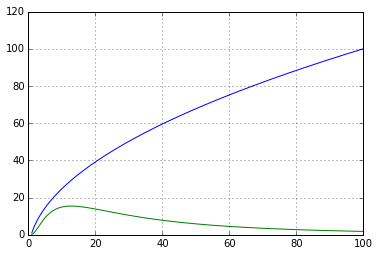

In [117]:
# quickly plot the initial conditions
plt.plot(xs, initial_guess_mu(xs))
plt.plot(xs, initial_guess_theta(xs))
plt.grid('on')

In [118]:
bvp_solver.solve(kind="Chebyshev",
                 coefs_dict=initial_coefs,
                 domain=domain)
viz = pycollocation.Visualizer(bvp_solver)

In [119]:
bvp_solver.result['success']

True

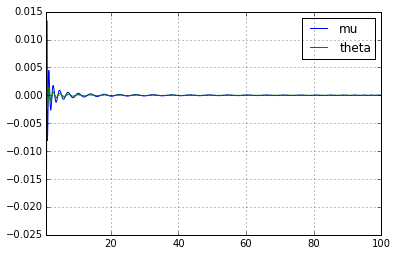

In [120]:
viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
viz.residuals.plot()

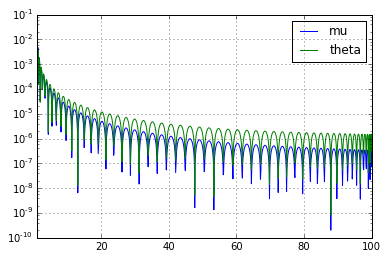

In [121]:
viz.normalized_residuals.plot(logy=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f3c8950>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10f445f10>], dtype=object)

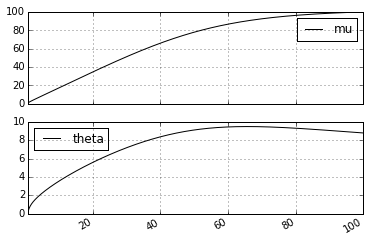

In [122]:
viz.solution.plot(subplots=True)

### Negative assortative matching

In [243]:
# negative assortativity requires that sigma_A * sigma_B > 1
F_params = {'omega_A':0.45, 'omega_B':0.5, 'sigma_A':1.05, 'sigma_B':1.05}

In [244]:
model = models.Model(assortativity='negative',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

In [245]:
mu, theta = sym.symbols('mu, theta')
rhs = {'mu': model.matching.mu_prime, 'theta': model.matching.theta_prime}

# specify some boundary conditions
bcs = {'lower': [mu - workers.upper], 'upper': [mu - workers.lower]}

bvp = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['mu', 'theta'],
                                                 independent_var='x',
                                                 rhs=rhs,
                                                 boundary_conditions=bcs,
                                                 params=model.params,  # need to use ALL params
                                                 )

In [246]:
# create the solver instance
bvp_solver = pycollocation.OrthogonalPolynomialSolver(bvp)

In [265]:
# specify the domain
domain = [workers.lower, workers.upper]

# initial guess for mu(x)
xs = np.linspace(domain[0], domain[1], 1000)
mus = get_initial_mus("negative", xs, 0.5)
initial_guess_mu = np.polynomial.Chebyshev.fit(xs, mus, 15, domain)

# initial guess for theta(x) should be consistent with mu(x) guess
H = workers.evaluate_pdf(xs) / firms.evaluate_pdf(initial_guess_mu(xs))
thetas = -(H / initial_guess_mu.deriv()(xs))  # use expression for mu'(x) 
initial_guess_theta = np.polynomial.Chebyshev.fit(xs, thetas, 95, domain)

# dictionary of coefficients...
initial_coefs = {'mu': initial_guess_mu.coef, 'theta': initial_guess_theta.coef}

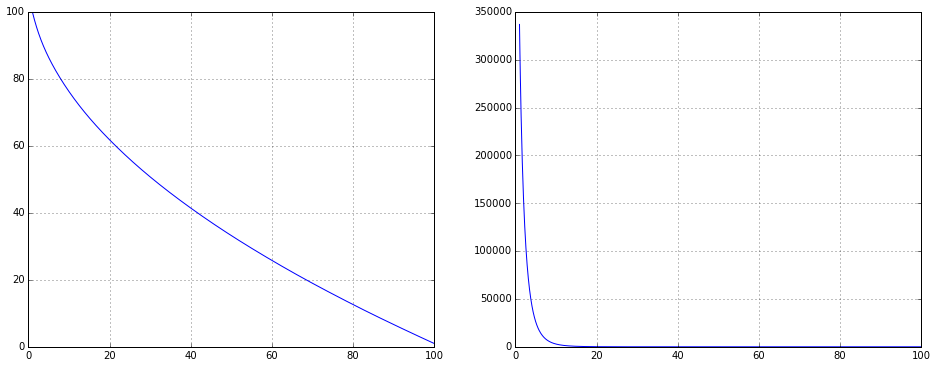

In [266]:
# quickly plot the initial conditions
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(xs, initial_guess_mu(xs))
axes[1].plot(xs, initial_guess_theta(xs))
axes[0].grid('on')
axes[1].grid('on')

In [267]:
initial_guess_theta(xs)

array([  3.36994466e+05,   3.09532156e+05,   2.84828441e+05,
         2.62556335e+05,   2.42432089e+05,   2.24209199e+05,
         2.07673201e+05,   1.92637182e+05,   1.78937936e+05,
         1.66432666e+05,   1.54996173e+05,   1.44518454e+05,
         1.34902649e+05,   1.26063292e+05,   1.17924805e+05,
         1.10420215e+05,   1.03490050e+05,   9.70813894e+04,
         9.11470487e+04,   8.56448714e+04,   8.05371210e+04,
         7.57899521e+04,   7.13729521e+04,   6.72587424e+04,
         6.34226312e+04,   5.98423104e+04,   5.64975900e+04,
         5.33701667e+04,   5.04434193e+04,   4.77022301e+04,
         4.51328270e+04,   4.27226438e+04,   4.04601983e+04,
         3.83349822e+04,   3.63373657e+04,   3.44585112e+04,
         3.26902974e+04,   3.10252514e+04,   2.94564882e+04,
         2.79776565e+04,   2.65828906e+04,   2.52667669e+04,
         2.40242649e+04,   2.28507326e+04,   2.17418545e+04,
         2.06936241e+04,   1.97023171e+04,   1.87644695e+04,
         1.78768559e+04,

In [268]:
bvp_solver.solve(kind="Chebyshev",
                 coefs_dict=initial_coefs,
                 domain=domain)
viz = pycollocation.Visualizer(bvp_solver)

In [269]:
bvp_solver.result["success"]

False

In [270]:
bvp_solver.result

  status: 5
 success: False
     qtf: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan])
    nfev: 235
       r: array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
     fun: array([ -9.23009750e+00,  -6.00702616e+00,  -3.96760919e+00,
        -2.97403840e+00,  -2.37726209e+00,  -1.99513225e+00,
       

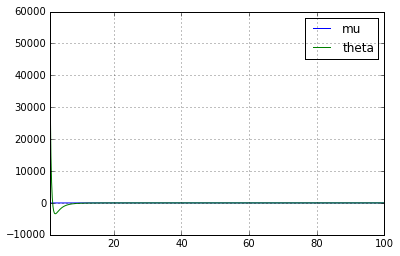

In [218]:
viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
viz.residuals.plot()

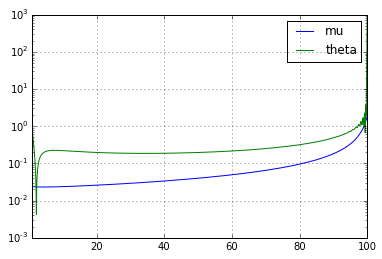

In [213]:
viz.normalized_residuals.plot(logy=True)

# Experimental section on widgets...

In [159]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [233]:
initial_coefs = {'mu': initial_guess_mu.coef, 'theta': initial_guess_theta.coef}

def plot_equilibrium(bvp, mu1=0.0, sigma1=1.0,
                     mu2=0.0, sigma2=1.0,
                     omega_A=0.5, sigma_A=0.5,
                     omega_B=0.5, sigma_B=0.5):
    bvp.params.update({'omega_A':omega_A, 'omega_B':omega_B,
                       'sigma_A':sigma_A, 'sigma_B':sigma_B,
                       'loc1': -1.0, 'mu1': mu1, 'sigma1': sigma1,
                       'loc2': -1.0, 'mu2': mu2, 'sigma2': sigma2})
    
    bvp_solver = pycollocation.OrthogonalPolynomialSolver(bvp)
    #global initial_coefs
    bvp_solver.solve(kind="Chebyshev",
                     coefs_dict=initial_coefs,
                     domain=domain)
    viz = pycollocation.Visualizer(bvp_solver)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
    
    viz.normalized_residuals.plot(logy=True, ax=axes[0])
    axes[0].set_title("Normalized residuals")
    axes[0].set_xlabel("$x$")
    
    viz.solution.plot(logy=True, ax=axes[1])
    axes[1].set_title("Solution functions")
    axes[1].set_xlabel("$x$")
    
    # use hot start ??
    #initial_coefs = bvp_solver.coefficients
    


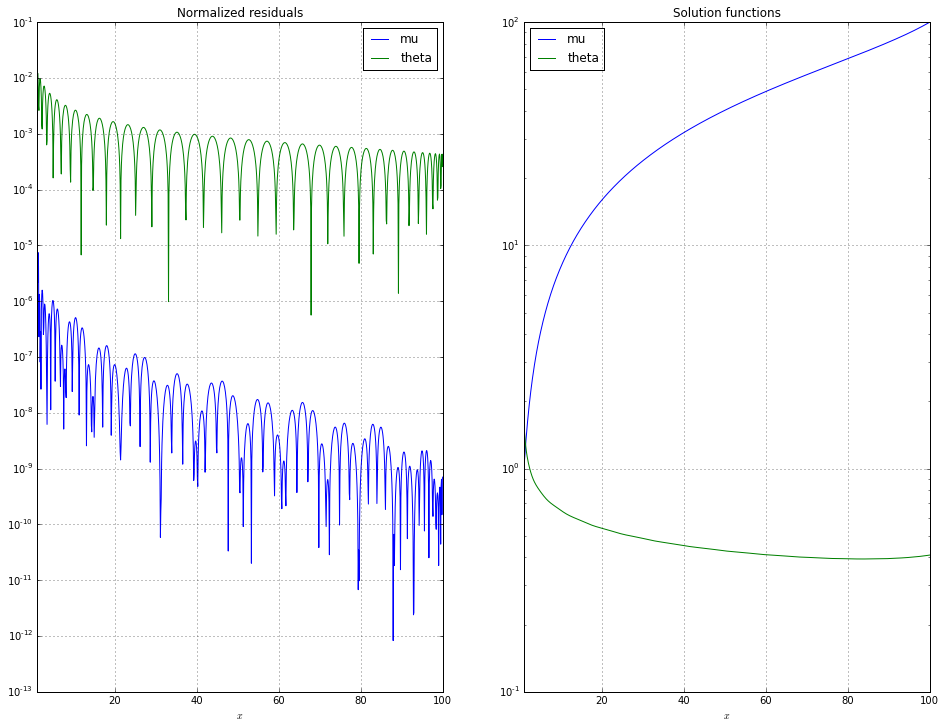

In [234]:
interact(plot_equilibrium,
         bvp=fixed(model2),
         omega_A=(0.0, 1.0, 1e-2),
         omega_B=(0.0, 1.0, 1e-2),
        )